In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from models.Resnet50 import resnet50
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [2]:
img_size = 64
batch_size = 20

In [3]:
# 先把根目錄用到food11
import os
# load dataset
dataset_dir = './food11'
# create new dir
try:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    for i in range(11):
        os.mkdir(f'train/{i:02d}')
        os.mkdir(f'valid/{i:02d}')
except:
    pass

In [4]:
# create new file structure for dataset
for sub_dir in ['training', 'validation', 'test']:
    target_dir = os.path.join(dataset_dir, sub_dir)
    img_list = os.listdir(target_dir)
    for img_name in img_list:
        category, *r = img_name.split('_')
        img_path = os.path.join(target_dir, img_name)
        if len(r) == 0:
            new_fn = f'{sub_dir}/{img_name}'
        else:
            category = int(category)
            new_fn = f'{sub_dir[:5]}/{category:02d}/{img_name}'
    # resize image
        os.rename(img_path, new_fn)

In [5]:
# Dataset preprocessing
import tensorflow as tf
valid_data_pro = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) #image augmentation
train_data = train_data_aug.flow_from_directory(
        'train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="sparse")
valid_data = valid_data_pro.flow_from_directory(
        'valid',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="sparse")
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    image_size=(img_size, img_size),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)
test_set = test_set.map(lambda x: (tf.divide(x, 255)))

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 files belonging to 1 classes.


In [6]:
model = resnet50()
model.summary()
plot_model(model, to_file=r'models\ResNet50.png', show_shapes=True)
##調整學習率，採用學習率隨epoch數上升呈遞減的狀態，避免一開始學習過慢，之後overshooting的情形
starter_learning_rate = 1e-2
end_learning_rate = 1e-3
decay_steps = 3000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(starter_learning_rate, decay_steps, end_learning_rate, power=0.6, cycle=True)
model_dir=r'.\models\Resnet50'
os.makedirs(model_dir)
log_dir = os.path.join('exam','model')
model_cbk=keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp=keras.callbacks.ModelCheckpoint(model_dir + '/Best_exam_model.h5', monitor='val_sparse_categorical_accuracy',save_best_only=True,mode='max')
model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy()])
##根據林益帆同學發現的結果，改用遷移學習，準確率可顯著提升
history_1=model.fit(train_data,epochs=30,validation_data=valid_data,callbacks=[model_cbk,model_mckp])

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

Epoch 1/30
494/494 [==============================] - 45s 72ms/step - loss: 17.4939 - sparse_categorical_accuracy: 0.1283 - val_loss: 11.3192 - val_sparse_categorical_accuracy: 0.1431
Epoch 2/30
494/494 [==============================] - 34s 70ms/step - loss: 12.0391 - sparse_categorical_accuracy: 0.1566 - val_loss: 10.5992 - val_sparse_categorical_accuracy: 0.2070
Epoch 3/30
494/494 [==============================] - 34s 68ms/step - loss: 11.1160 - sparse_categorical_accuracy: 0.1865 - val_loss: 10.2313 - val_sparse_categorical_accuracy: 0.2402
Epoch 4/30
494/494 [==============================] - 34s 69ms/step - loss: 10.6399 - sparse_categorical_accuracy: 0.2057 - val_loss: 9.9824 - val_sparse_categorical_accuracy: 0.2554
Epoch 5/30
494/494 [==============================] - 38s 76ms/step - loss: 10.3337 - sparse_categorical_accuracy: 0.2328 - val_loss: 9.8540 - val_sparse_categorical_accuracy: 0.3073
Epoch 6/30
494/494 [==============================] - 38s 78ms/step - loss: 10.115

In [7]:
model.load_weights('models\Resnet50\Best_exam_model.h5')
answer = model.predict(test_set)
df = pd.DataFrame()
df["Id"] = ["0"*(4-len(str(i)))+str(i) for i in range(1,np.shape(answer)[0]+1)]
def get_class(i):
    top_1_index = np.argsort(answer[i])[10]
    return top_1_index 
df["Category"] = [get_class(i) for i in range(0,np.shape(answer)[0])]
df.to_csv("test_result\submission_2.csv",index = False)

Kaggle連結 https://www.kaggle.com/competitions/ml2022spring-hw3b/submissions
連結內的submission_2.csv是根據此Resnet 50精簡版(拿掉filters=2048的Res_identity以及Res_conv訓練層，避免參數過多run out of GPU)，此模型的residual block是根據問題一的左側流程圖(即github內的left flow chart.png)做設計的。預測的準確度為41.5%，雖然偏低，不過因為堆疊的層數不多，而且沒有使用遷移學習方法讓參數變少，所以結果還算差強人意。

後續繳交的submission_X.csv是根據問題一的右側流程圖(即github內的right flow chart.png)做設計的，其模型建立由Resnet50_multiply model training.ipynb設計的，之後會有針對此新模型的預測率的心得。

下圖是關於此次模型的預測結果。
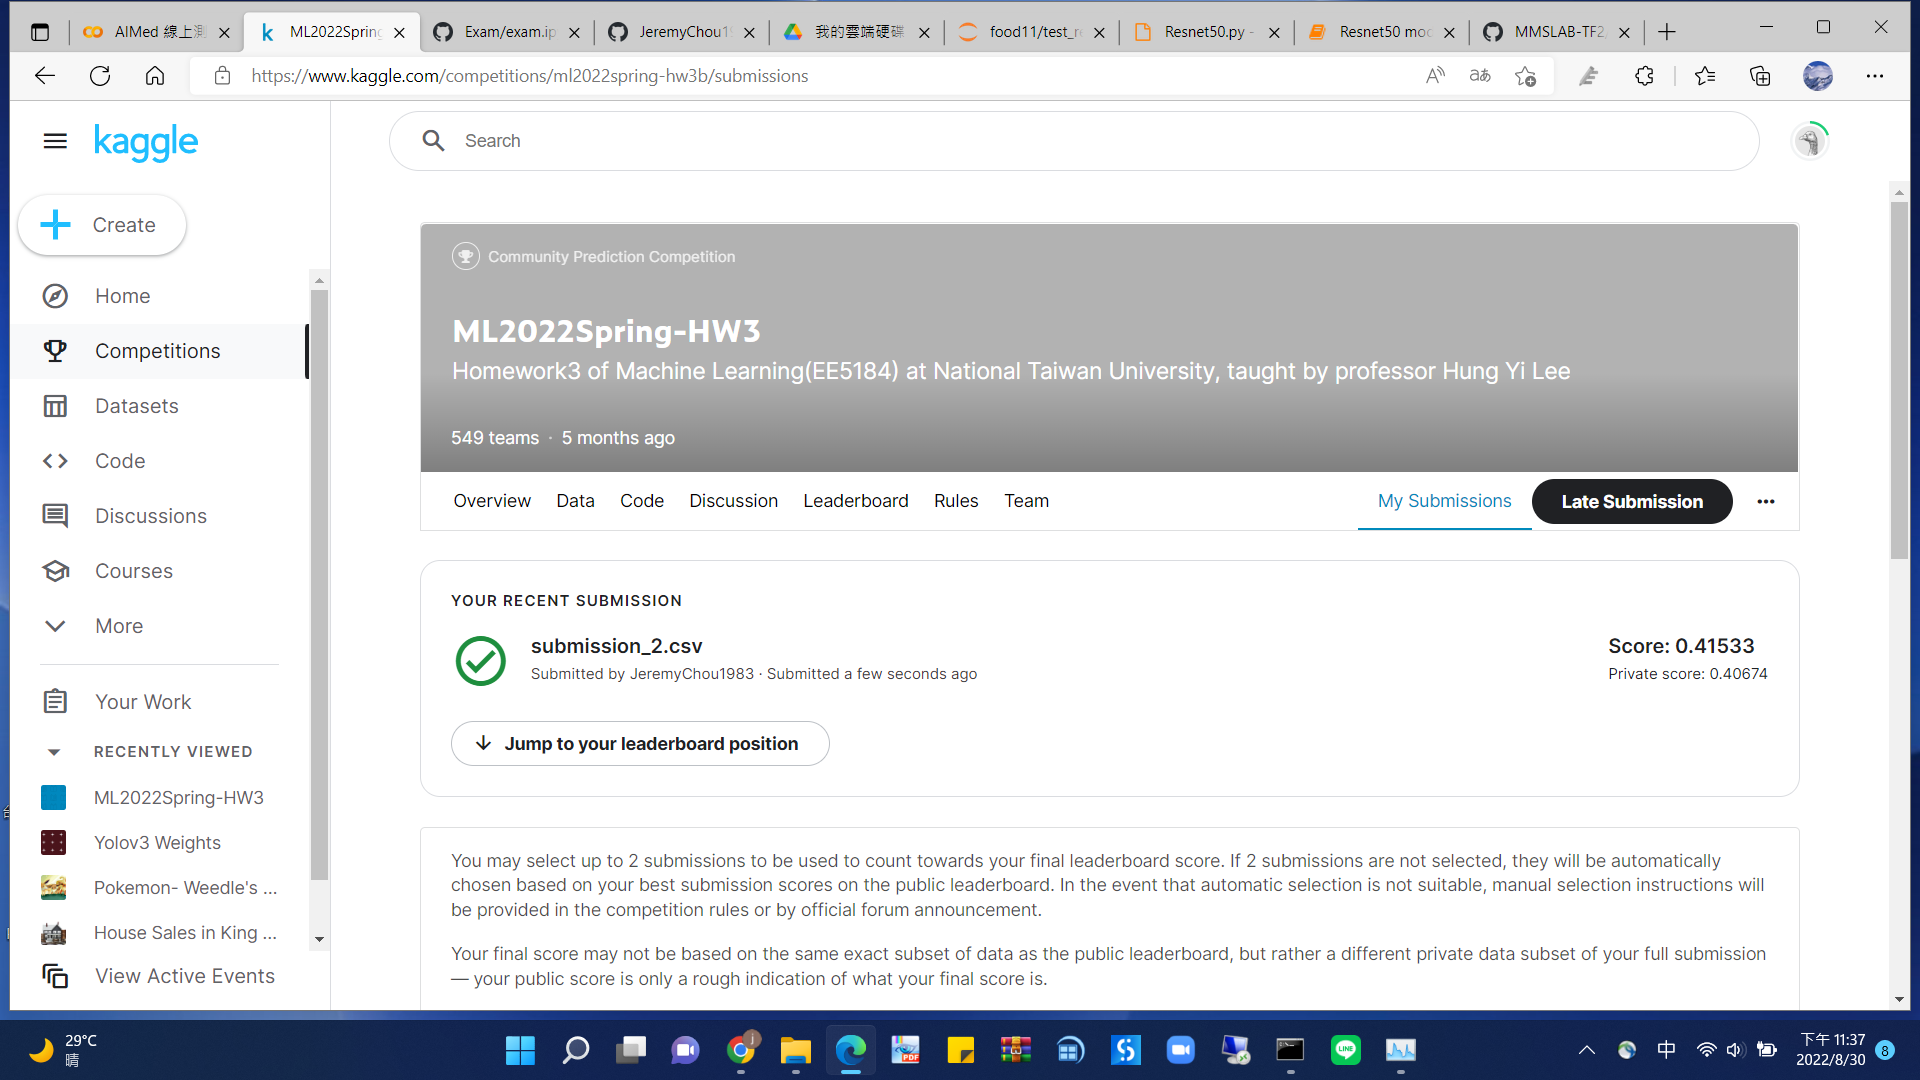